# 05 Alternative gaussian regression model 

> Implemented using metropolis hastings

In [1]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02c_GP_doctors_per_LAD.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [2]:
#|default_exp core.05b_alt_gaussian_regression_model

In [3]:
#|hide 
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj 
from dementia_inequalities import const, log, utils, tools 
import adu_proj.utils as adutils 

In [5]:
#|export 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

from scipy.stats import norm 


---

## Normal error

Assume the error is normally distributed, $\epsilon \sim N(\mu, \sigma)$ with $\mu >0$.

In [40]:
#|export 

# Define the log likelihood function for linear regression with normal error
def log_likelihood(params, X, y):
    beta_0 = params[0]
    beta = params[1:-2]
    mu = params[-2]
    sigma = params[-1]

    y_pred = np.dot(X, beta) + beta_0 
    y_diff = y_pred.squeeze()-y
    likelihood = norm.pdf(x=y_diff, loc=mu, scale=sigma)
    
    return np.sum(np.log(likelihood))

# Define the prior distribution for beta parameters, mu, and sigma
def log_prior(params):
    beta_0 = params[0]
    beta = params[1:-2]
    mu = params[-2]
    sigma = params[-1]
    if all(-1 < b < 1 for b in beta) and 0 <= beta_0 < 1 and 0 < mu < 1 and 0 < sigma < 1 :
    #if all(-5 < b < 5 for b in beta) and 0 <= beta_0 < 5 and 0 < mu < 5 and 0 < sigma :
    #if all(-5 < b < 5 for b in beta) and 0 <= beta_0 < 5 and -5 < mu < 0 and 0 < sigma :
        return 0
    return -np.inf

# Define the log posterior distribution
def log_posterior(params, X, y):
    return log_likelihood(params, X, y) + log_prior(params)

# Define the Metropolis-Hastings algorithm
def metropolis_hastings(initial_params, proposal_sd, n_iter, X, y):
    params = initial_params
    accepted_params = [params]
    accepted_post = [log_posterior(params, X, y)]
    for _ in range(n_iter):
        proposed_params = params + np.random.normal(scale=proposal_sd, size=params.shape)
        log_alpha = log_posterior(proposed_params, X, y) - log_posterior(params, X, y)
        if np.log(np.random.rand()) < log_alpha:
            params = proposed_params
        accepted_params.append(params)
        accepted_post.append(log_posterior(params, X, y))
    return np.array(accepted_params), np.array(accepted_post)

In [7]:
# Generate some sample data with 7 covariates
np.random.seed(0)
n_samples = 1000
n_features = 7

X = np.random.rand(n_samples, n_features) * 10  # Independent variables

true_beta_0 = 0.5
true_beta = np.random.normal(loc=2, scale=1, size=X.shape[1])  # True coefficients
true_mu = 2  # True mean of log-normal distribution
true_sigma = 0.5
true_error = np.random.normal(loc=true_mu, scale=true_sigma, size=n_samples)  # Log-normal error term
y = np.dot(X, true_beta) + true_beta_0 - true_error  # True relationship with error

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_5197/1225449560.py:14: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(likelihood))
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_5197/1225449560.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  log_alpha = log_posterior(proposed_params, X, y) - log_posterior(params, X, y)


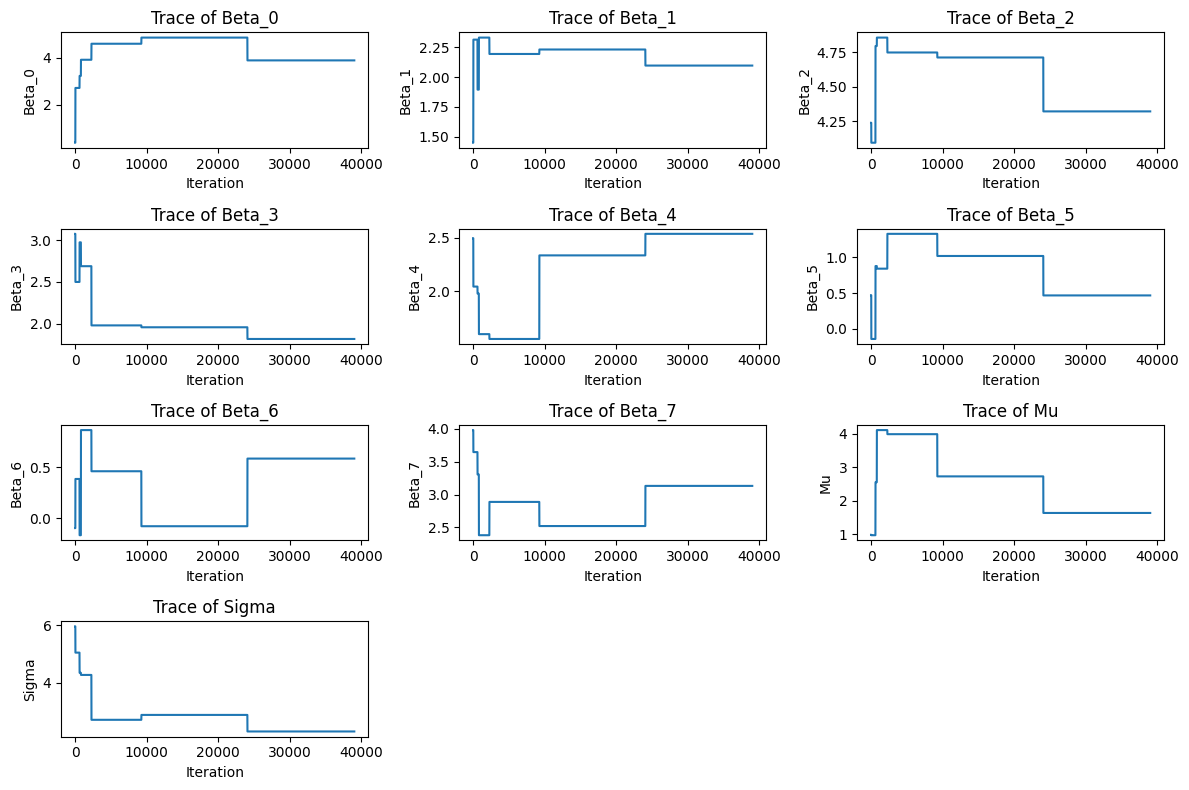

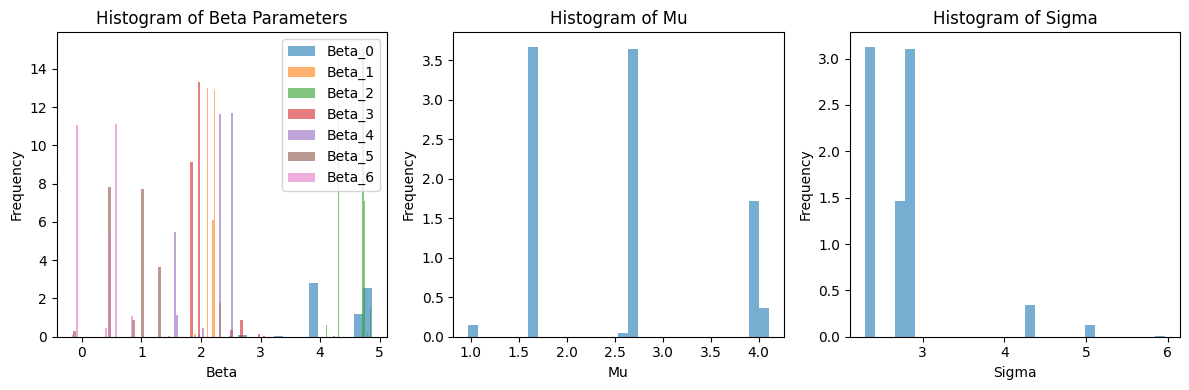

In [8]:
# Set initial parameters and proposal standard deviation
initial_params = np.concatenate([np.random.normal(size=n_features+1), [1.5, 1]])  # Initial beta parameters, mu, and sigma
proposal_sd = 1

# Run Metropolis-Hastings algorithm
n_iter = 40000
chain, post = metropolis_hastings(initial_params, proposal_sd, n_iter, X, y)

# Burn-in (discard first part of the chain)
burn_in = 1000
burned_chain = chain[burn_in:]

# Extract beta parameters, mu, and sigma from the chain
beta_samples, mu_samples, sigma_samples = burned_chain[:, :-2], burned_chain[:, -2], burned_chain[:, -1]

# Plot the traces and histograms of beta parameters, mu, and sigma
plt.figure(figsize=(12, 8))

beta_vals = beta_samples.shape[1]

for i in range(beta_vals):
    plt.subplot(4, 3, i+1)
    plt.plot(beta_samples[:, i])
    plt.xlabel('Iteration')
    plt.ylabel(f'Beta_{i}')
    plt.title(f'Trace of Beta_{i}')

plt.subplot(4, 3, beta_vals+1)
plt.plot(mu_samples)
plt.xlabel('Iteration')
plt.ylabel('Mu')
plt.title('Trace of Mu')

plt.subplot(4, 3, beta_vals+2)
plt.plot(sigma_samples)
plt.xlabel('Iteration')
plt.ylabel('Sigma')
plt.title('Trace of Sigma')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
for i in range(n_features):
    plt.hist(beta_samples[:, i], bins=30, density=True, alpha=0.6, label=f'Beta_{i}')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.title('Histogram of Beta Parameters')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(mu_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Mu')
plt.ylabel('Frequency')
plt.title('Histogram of Mu')

plt.subplot(1, 3, 3)
plt.hist(sigma_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.title('Histogram of Sigma')

plt.tight_layout()
plt.show()

In [9]:
# Extract the MAP from the parameter samples
MAP_params = chain[np.argmax(post)]
MAP_beta = MAP_params[:-2]
MAP_mu = MAP_params[-2]
MAP_sigma = MAP_params[-1]

print("MAP estimates:")
print("Beta:", MAP_beta)
print("Mu:", MAP_mu)
print("Sigma:", MAP_sigma)

MAP estimates:
Beta: [3.89523135 2.09679406 4.32250526 1.81728592 2.53580078 0.46612358
 0.58450662 3.13076341]
Mu: 1.6374250155264625
Sigma: 2.2914788203509877


In [10]:
print("True parameter values:")
print(f"Beta: {true_beta_0} {true_beta}")
print("Mu:", true_mu)
print("Sigma:", true_sigma)

True parameter values:
Beta: 0.5 [2.33262315 4.49599456 2.3348725  2.24408513 0.91852546 0.32878941
 3.0294515 ]
Mu: 2
Sigma: 0.5


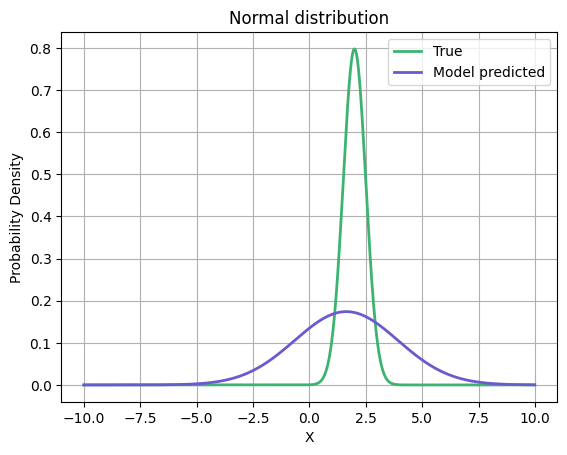

In [11]:
# Compare the true normal to that from the model 

x = np.arange(-10, 10, 0.01)

pdf_x_true = norm.pdf(x, true_mu, true_sigma)
pdf_x_MAP = norm.pdf(x, MAP_mu, MAP_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x, pdf_x_true, '-', linewidth=2, color='mediumseagreen', label='True')
plt.plot(x, pdf_x_MAP, '-', linewidth=2, color='slateblue', label='Model predicted')

plt.title('Normal distribution')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

### With the real data! 

In [13]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.001138


In [41]:
# The real dementia X and y data 

# covariates 
covar = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']
X_covar = df_dem_plus[covar].values.reshape(-1,7)

# Outcome data 
Y_data = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

In [42]:
# Model parameters 

# Initial values 
beta_initial = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
mu = 0.1
sigma = 0.25
initial_params = np.concatenate([beta_initial, [mu, sigma]])  # Initial beta parameters, mu, and sigma

# standard deviation for sampling 
proposal_sd = 0.5

In [43]:
# Run Metropolis-Hastings algorithm
n_iter = 40000
chain, post = metropolis_hastings(initial_params, proposal_sd, n_iter, X_covar, Y_data)

# Burn-in (discard first part of the chain)
burn_in = 1000
burned_chain = chain[burn_in:]

# Extract beta parameters, mu, and sigma from the chain
beta_samples, mu_samples, sigma_samples = burned_chain[:, :-2], burned_chain[:, -2], burned_chain[:, -1]

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_5197/3249502593.py:14: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(likelihood))
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_5197/3249502593.py:39: RuntimeWarning: invalid value encountered in scalar subtract
  log_alpha = log_posterior(proposed_params, X, y) - log_posterior(params, X, y)


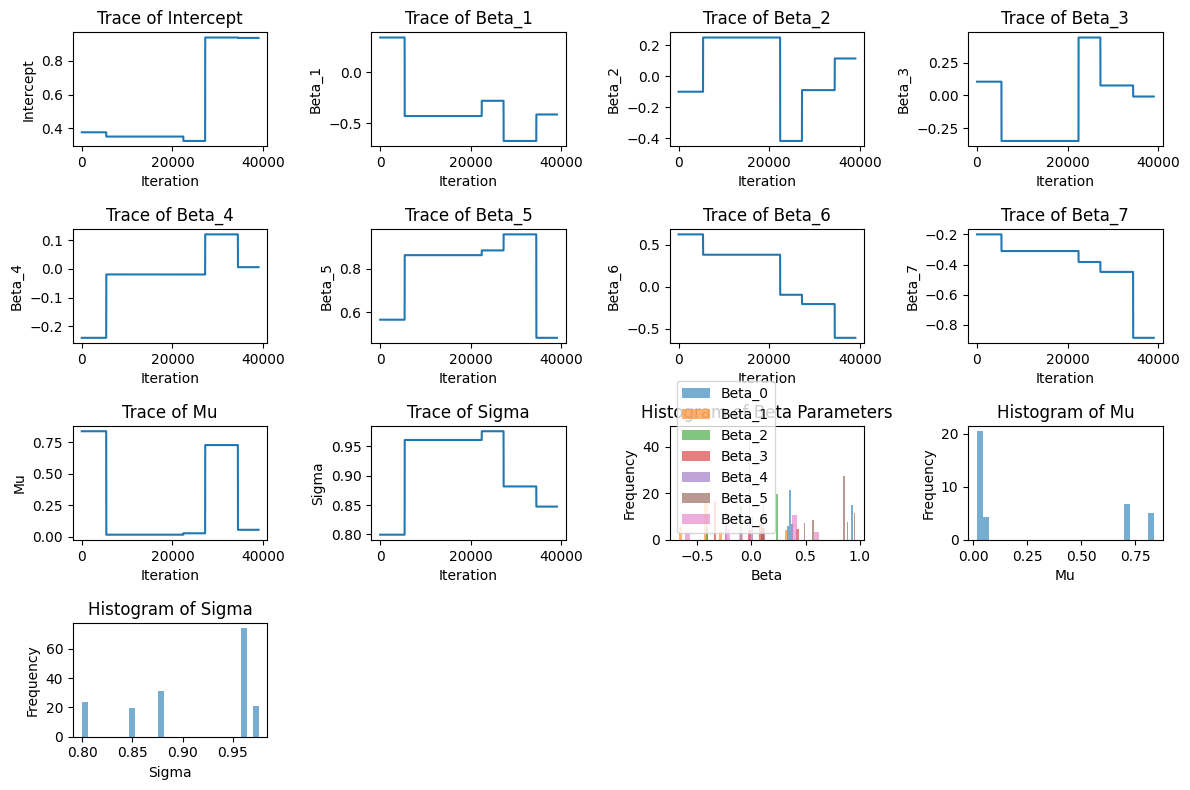

In [44]:
# Plot the traces and histograms of beta parameters, mu, and sigma
plt.figure(figsize=(12, 8))

plt.subplot(4, 4, 1)
plt.plot(beta_samples[:, 0])
plt.xlabel('Iteration')
plt.ylabel('Intercept')
plt.title('Trace of Intercept')

for i in range(1, n_features+1):
    plt.subplot(4, 4, i+1)
    plt.plot(beta_samples[:, i])
    plt.xlabel('Iteration')
    plt.ylabel(f'Beta_{i}')
    plt.title(f'Trace of Beta_{i}')

plt.subplot(4, 4, n_features+2)
plt.plot(mu_samples)
plt.xlabel('Iteration')
plt.ylabel('Mu')
plt.title('Trace of Mu')

plt.subplot(4, 4, n_features+3)
plt.plot(sigma_samples)
plt.xlabel('Iteration')
plt.ylabel('Sigma')
plt.title('Trace of Sigma')

plt.subplot(4, 4, n_features+4)
for i in range(n_features):
    plt.hist(beta_samples[:, i], bins=30, density=True, alpha=0.6, label=f'Beta_{i}')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.title('Histogram of Beta Parameters')
plt.legend()

plt.subplot(4, 4, n_features+5)
plt.hist(mu_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Mu')
plt.ylabel('Frequency')
plt.title('Histogram of Mu')

plt.subplot(4, 4, n_features+6)
plt.hist(sigma_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.title('Histogram of Sigma')

plt.tight_layout()
plt.show()

In [45]:
# Extract the MAP from the parameter samples
MAP_params = chain[np.argmax(post)]
MAP_beta = MAP_params[:-2]
MAP_mu = MAP_params[-2]
MAP_sigma = MAP_params[-1]

print("MAP estimates:")
print("Intercept")
print(f'Intercept:{MAP_beta[0]}')
print("Beta")
for i, var in enumerate(covar):
    print(f'{var}:{MAP_beta[i+1]}')
print("Mu:", MAP_mu)
print("Sigma:", MAP_sigma)

MAP estimates:
Intercept
Intercept:0.9351468796496164
Beta
over_65_pc:-0.41210111399577104
female_pc:0.11355297947255383
ALevel_plus_pc:-0.009385208110845006
white_pc:0.006048856550927545
HYP_afflicted_pc:0.4820073273427257
DM_afflicted_pc:-0.6083458572130124
STIA_afflicted_pc:-0.8861038526739311
Mu: 0.055416376657526634
Sigma: 0.8472930125571234


In [49]:
print(f'This is the log posterior at the MAP parameter estimate: {log_posterior(MAP_params, X_covar, Y_data)}')

This is the log posterior at the MAP parameter estimate: -394094.94708738604


In [52]:
params = [0.25, 0.016, 0.0065, -0.006, -0.0045, 0.01, -0.024, 0.24, 0.3, 0.5]
print(f'This is the log posterior at my best guess {log_posterior(params, X_covar, Y_data)} \nWhich is based on the coefficients of the linear regression model plus info from the literature.')

This is the log posterior at my best guess -43526.76234648134 
Which is based on the coefficients of the linear regression model plus info from the literature.
